# Space-Filling Curve Sparse Encoder

This notebook demonstrates a novel tokenization approach for sparse data using space-filling curves.

## Background: Vision Transformer Patchification

Standard ViT approach for 32×32 images:
- Divide into patches (e.g., 4×4 patches → 8×8 grid = 64 patches)
- Each patch becomes a token
- Result: 64 tokens for transformer

## Our Approach: Sparse Data Tokenization

For sparse data (e.g., 25% density = 256 random points in 32×32 space):
1. **Sparsify**: Keep only 25% of pixels (256 out of 1024)
2. **Serialize**: Use space-filling curve (Z-order or Hilbert) to order 2D points in 1D
3. **Group**: Combine every g=8 points into a token → 256/8 = 32 tokens

### Why Space-Filling Curves?
- **Locality preservation**: Nearby points in 2D tend to be nearby in 1D
- **Natural grouping**: Points that are spatially close get grouped into same token
- **Efficient processing**: Works with irregular/sparse point distributions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Part 1: Space-Filling Curves

Space-filling curves map multi-dimensional space to 1D while preserving locality.

### Z-Order (Morton) Curve
- Interleaves bits of x and y coordinates
- Creates Z-shaped pattern at each scale
- Simple to compute

### Hilbert Curve
- Better locality preservation than Z-order
- More complex to compute
- Continuous (no jumps)

In [2]:
# ============================================================================
# SPACE-FILLING CURVE IMPLEMENTATIONS
# ============================================================================

def xy_to_zorder(x, y, bits=5):
    """
    Convert (x, y) to Z-order (Morton code) index.
    
    Z-order interleaves the bits of x and y:
    x = x4 x3 x2 x1 x0
    y = y4 y3 y2 y1 y0
    z = y4 x4 y3 x3 y2 x2 y1 x1 y0 x0
    
    Args:
        x, y: Coordinates (0 to 2^bits - 1)
        bits: Number of bits for each coordinate
    
    Returns:
        Z-order index
    """
    z = 0
    for i in range(bits):
        z |= ((x & (1 << i)) << i) | ((y & (1 << i)) << (i + 1))
    return z


def zorder_to_xy(z, bits=5):
    """
    Convert Z-order index back to (x, y).
    """
    x = 0
    y = 0
    for i in range(bits):
        x |= ((z >> (2 * i)) & 1) << i
        y |= ((z >> (2 * i + 1)) & 1) << i
    return x, y


def xy_to_hilbert(x, y, order=5):
    """
    Convert (x, y) to Hilbert curve index.
    
    The Hilbert curve has better locality than Z-order:
    consecutive indices are always adjacent in 2D space.
    
    Args:
        x, y: Coordinates (0 to 2^order - 1)
        order: Hilbert curve order (n = 2^order)
    
    Returns:
        Hilbert curve index
    """
    n = 1 << order  # 2^order
    d = 0
    s = n >> 1
    
    while s > 0:
        rx = 1 if (x & s) > 0 else 0
        ry = 1 if (y & s) > 0 else 0
        d += s * s * ((3 * rx) ^ ry)
        
        # Rotate
        if ry == 0:
            if rx == 1:
                x = s - 1 - x
                y = s - 1 - y
            x, y = y, x
        
        s >>= 1
    
    return d


def hilbert_to_xy(d, order=5):
    """
    Convert Hilbert curve index back to (x, y).
    """
    n = 1 << order
    x = y = 0
    s = 1
    
    while s < n:
        rx = 1 & (d // 2)
        ry = 1 & (d ^ rx)
        
        # Rotate
        if ry == 0:
            if rx == 1:
                x = s - 1 - x
                y = s - 1 - y
            x, y = y, x
        
        x += s * rx
        y += s * ry
        d //= 4
        s *= 2
    
    return x, y


print("Space-filling curve functions defined!")
print(f"Example: (5, 3) -> Z-order: {xy_to_zorder(5, 3)}, Hilbert: {xy_to_hilbert(5, 3)}")

Space-filling curve functions defined!
Example: (5, 3) -> Z-order: 27, Hilbert: 52


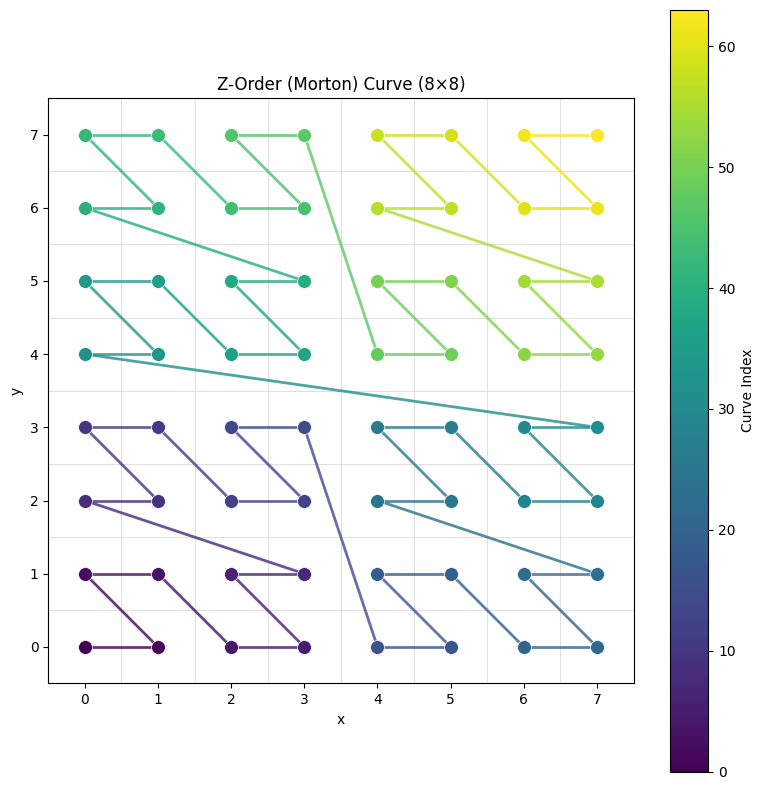

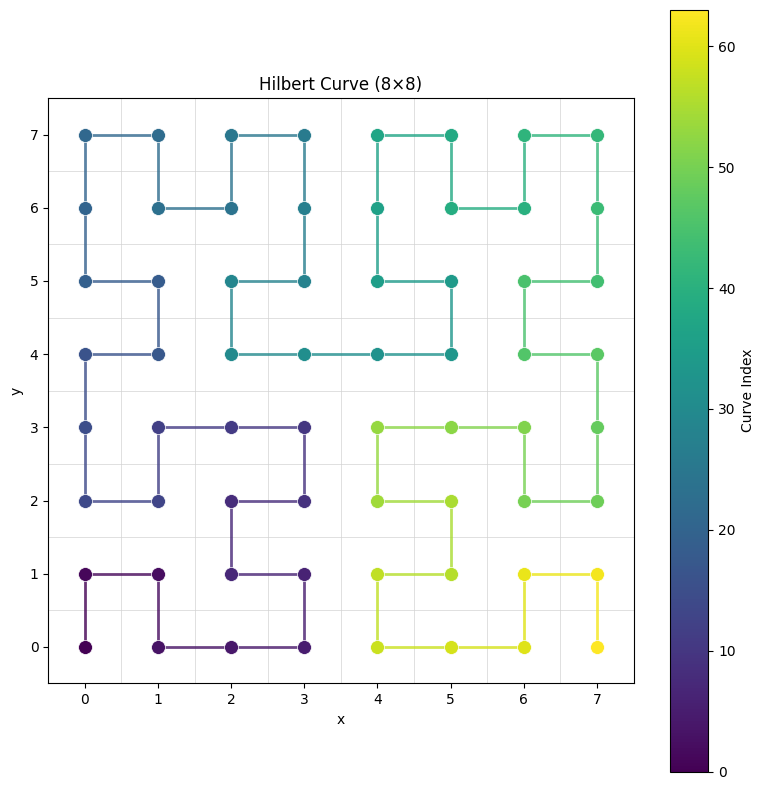

In [3]:
# ============================================================================
# VISUALIZE SPACE-FILLING CURVES
# ============================================================================

def visualize_curve(curve_func, size=8, title="Space-Filling Curve"):
    """
    Visualize a space-filling curve on a grid.
    """
    order = int(np.log2(size))
    n_points = size * size
    
    # Generate curve path
    if 'hilbert' in curve_func.__name__:
        # For Hilbert, we iterate through indices
        points = [hilbert_to_xy(i, order) for i in range(n_points)]
    else:
        # For Z-order, generate all points and sort by Z-index
        all_points = [(x, y, xy_to_zorder(x, y, order)) for x in range(size) for y in range(size)]
        all_points.sort(key=lambda p: p[2])
        points = [(p[0], p[1]) for p in all_points]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw grid
    for i in range(size + 1):
        ax.axhline(y=i - 0.5, color='lightgray', linewidth=0.5)
        ax.axvline(x=i - 0.5, color='lightgray', linewidth=0.5)
    
    # Draw curve path
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    
    # Color by index (early = blue, late = red)
    colors = plt.cm.viridis(np.linspace(0, 1, len(points)))
    
    for i in range(len(points) - 1):
        ax.plot([xs[i], xs[i+1]], [ys[i], ys[i+1]], 
                color=colors[i], linewidth=2, alpha=0.8)
    
    # Mark points with their index
    for i, (x, y) in enumerate(points):
        ax.scatter(x, y, c=[colors[i]], s=100, zorder=5, edgecolors='white', linewidth=0.5)
        if size <= 8:
            ax.annotate(str(i), (x, y), ha='center', va='center', 
                       fontsize=6, color='white', fontweight='bold')
    
    ax.set_xlim(-0.5, size - 0.5)
    ax.set_ylim(-0.5, size - 0.5)
    ax.set_aspect('equal')
    ax.set_title(f"{title} ({size}×{size})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(0, n_points-1))
    cbar = plt.colorbar(sm, ax=ax, label='Curve Index')
    
    plt.tight_layout()
    return fig


# Visualize both curves on small grid
fig1 = visualize_curve(xy_to_zorder, size=8, title="Z-Order (Morton) Curve")
plt.show()

fig2 = visualize_curve(xy_to_hilbert, size=8, title="Hilbert Curve")
plt.show()

## Part 2: CIFAR-10 Data Loading

Load CIFAR-10 and prepare for sparse tokenization demonstration.

100%|██████████| 170M/170M [00:05<00:00, 33.7MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
CIFAR-10 loaded: 50000 images
Image shape: torch.Size([3, 32, 32]) (C, H, W)


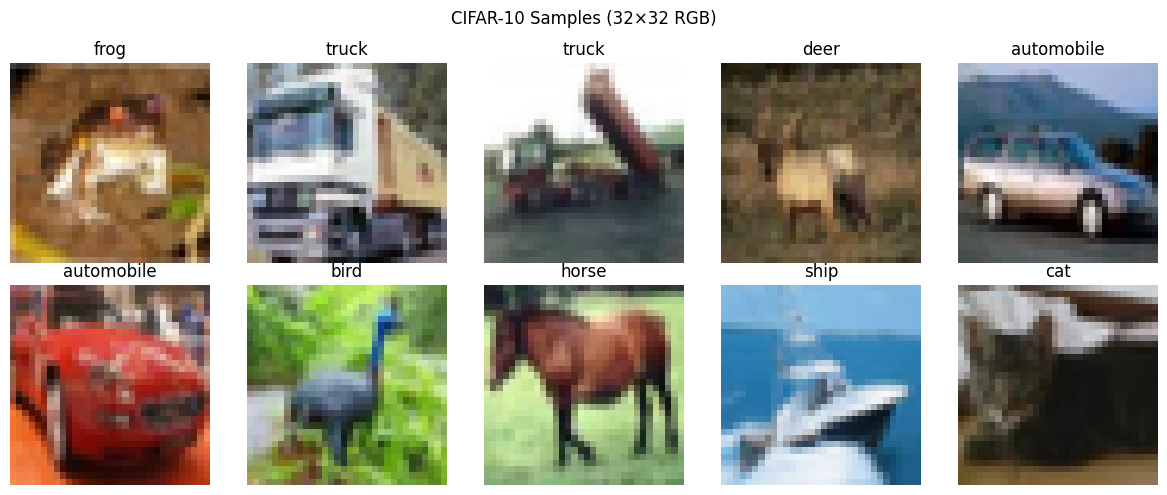

In [4]:
import torchvision
import torchvision.transforms as transforms

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar10 = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 loaded: {len(cifar10)} images")
print(f"Image shape: {cifar10[0][0].shape} (C, H, W)")

# Display a few samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = cifar10[i]
    ax.imshow(img.permute(1, 2, 0))  # CHW -> HWC
    ax.set_title(CIFAR10_CLASSES[label])
    ax.axis('off')
plt.suptitle("CIFAR-10 Samples (32×32 RGB)")
plt.tight_layout()
plt.show()

## Part 3: Standard ViT Patchification (Comparison)

First, let's see how standard Vision Transformer handles the image:
- 32×32 image with 4×4 patches → 8×8 = 64 patches → 64 tokens

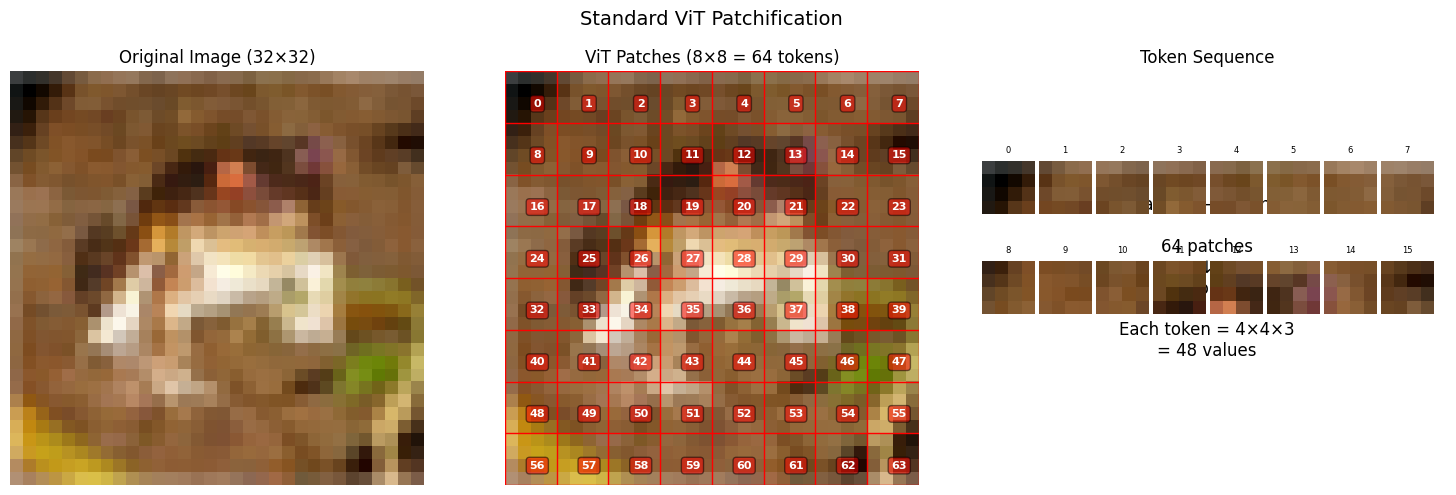


Standard ViT Summary:
  Input: 32×32×3 = 3072 values
  Patches: 8×8 = 64 patches of 4×4×3
  Tokens: 64 tokens


In [5]:
def visualize_vit_patchification(image, patch_size=4):
    """
    Visualize standard ViT patchification.
    """
    C, H, W = image.shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    num_patches = num_patches_h * num_patches_w
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title(f"Original Image ({H}×{W})")
    axes[0].axis('off')
    
    # Image with patch grid overlay
    axes[1].imshow(image.permute(1, 2, 0))
    for i in range(num_patches_h + 1):
        axes[1].axhline(y=i * patch_size - 0.5, color='red', linewidth=1)
    for j in range(num_patches_w + 1):
        axes[1].axvline(x=j * patch_size - 0.5, color='red', linewidth=1)
    
    # Number patches
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            patch_idx = i * num_patches_w + j
            axes[1].text(j * patch_size + patch_size/2, i * patch_size + patch_size/2,
                        str(patch_idx), ha='center', va='center', 
                        color='white', fontsize=8, fontweight='bold',
                        bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
    axes[1].set_title(f"ViT Patches ({num_patches_h}×{num_patches_w} = {num_patches} tokens)")
    axes[1].axis('off')
    
    # Show patches as sequence
    # Reshape image into patches
    patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.permute(1, 2, 0, 3, 4).reshape(num_patches, C, patch_size, patch_size)
    
    # Display first 16 patches
    for i in range(min(16, num_patches)):
        ax_sub = fig.add_axes([0.68 + (i % 8) * 0.038, 0.55 - (i // 8) * 0.2, 0.035, 0.15])
        ax_sub.imshow(patches[i].permute(1, 2, 0))
        ax_sub.set_title(str(i), fontsize=6)
        ax_sub.axis('off')
    
    axes[2].text(0.5, 0.5, f"Patches → Tokens\n\n{num_patches} patches\n↓\n{num_patches} tokens\n\nEach token = {patch_size}×{patch_size}×{C}\n= {patch_size*patch_size*C} values",
                ha='center', va='center', fontsize=12, transform=axes[2].transAxes)
    axes[2].axis('off')
    axes[2].set_title("Token Sequence")
    
    plt.suptitle("Standard ViT Patchification", fontsize=14)
    plt.tight_layout()
    return fig


# Visualize for first image
sample_img, sample_label = cifar10[0]
fig = visualize_vit_patchification(sample_img, patch_size=4)
plt.show()

print("\nStandard ViT Summary:")
print(f"  Input: 32×32×3 = 3072 values")
print(f"  Patches: 8×8 = 64 patches of 4×4×3")
print(f"  Tokens: 64 tokens")

## Part 4: Sparsification

Now let's sparsify the data to 25%:
- 32×32 = 1024 pixels
- 25% = 256 random pixels

This simulates sparse data scenarios like:
- LiDAR point clouds
- Sparse sensor readings
- Masked/incomplete images

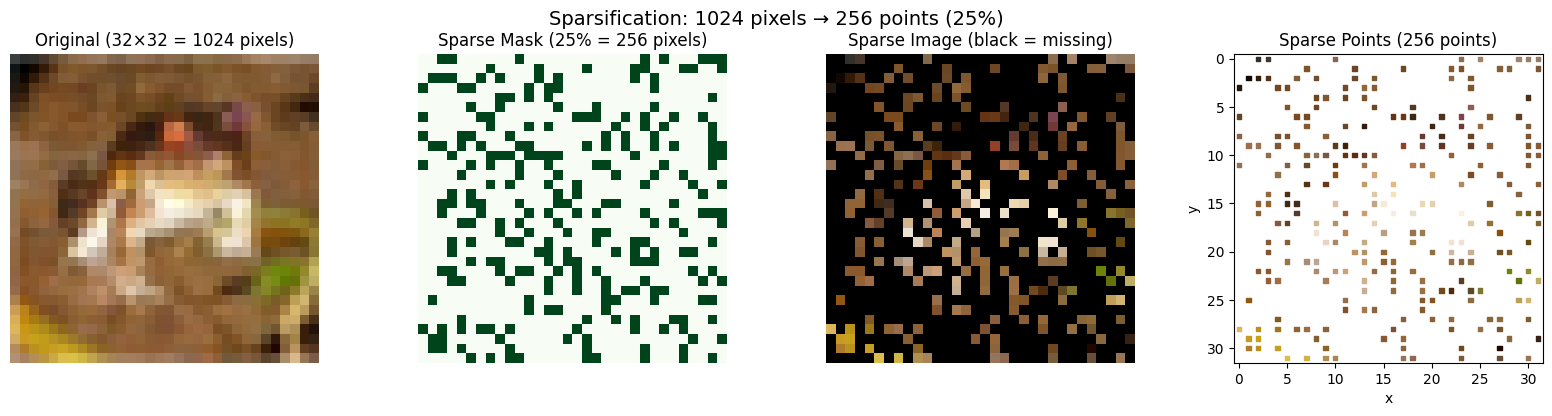


Sparsification Summary:
  Original: 32×32 = 1024 pixels
  Sparse: 256 pixels (25%)
  Each point: (x, y, RGB) = 5 values


In [6]:
def sparsify_image(image, sparsity=0.25, seed=None):
    """
    Randomly sparsify an image to keep only a fraction of pixels.
    
    Args:
        image: Tensor [C, H, W]
        sparsity: Fraction of pixels to keep (0.25 = 25%)
        seed: Random seed for reproducibility
    
    Returns:
        sparse_coords: List of (x, y) coordinates of kept pixels
        sparse_values: Tensor [N, C] of pixel values at those coordinates
        mask: Boolean mask [H, W] showing which pixels are kept
    """
    if seed is not None:
        np.random.seed(seed)
    
    C, H, W = image.shape
    total_pixels = H * W
    num_keep = int(total_pixels * sparsity)
    
    # Generate all pixel coordinates
    all_coords = [(x, y) for y in range(H) for x in range(W)]
    
    # Randomly select pixels to keep
    keep_indices = np.random.choice(total_pixels, size=num_keep, replace=False)
    sparse_coords = [all_coords[i] for i in keep_indices]
    
    # Extract values at those coordinates
    sparse_values = torch.stack([image[:, y, x] for x, y in sparse_coords])
    
    # Create mask
    mask = np.zeros((H, W), dtype=bool)
    for x, y in sparse_coords:
        mask[y, x] = True
    
    return sparse_coords, sparse_values, mask


def visualize_sparsification(image, sparsity=0.25, seed=42):
    """
    Visualize the sparsification process.
    """
    sparse_coords, sparse_values, mask = sparsify_image(image, sparsity, seed)
    
    C, H, W = image.shape
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Original image
    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title(f"Original ({H}×{W} = {H*W} pixels)")
    axes[0].axis('off')
    
    # Mask visualization
    axes[1].imshow(mask, cmap='Greens')
    axes[1].set_title(f"Sparse Mask ({sparsity*100:.0f}% = {len(sparse_coords)} pixels)")
    axes[1].axis('off')
    
    # Sparse image (black background)
    sparse_img = torch.zeros_like(image)
    for (x, y), val in zip(sparse_coords, sparse_values):
        sparse_img[:, y, x] = val
    axes[2].imshow(sparse_img.permute(1, 2, 0))
    axes[2].set_title("Sparse Image (black = missing)")
    axes[2].axis('off')
    
    # Scatter plot of sparse points
    xs = [c[0] for c in sparse_coords]
    ys = [c[1] for c in sparse_coords]
    colors = sparse_values.numpy()  # [N, 3] RGB values
    axes[3].scatter(xs, ys, c=colors, s=10, marker='s')
    axes[3].set_xlim(-0.5, W - 0.5)
    axes[3].set_ylim(H - 0.5, -0.5)  # Flip y-axis
    axes[3].set_aspect('equal')
    axes[3].set_title(f"Sparse Points ({len(sparse_coords)} points)")
    axes[3].set_xlabel("x")
    axes[3].set_ylabel("y")
    
    plt.suptitle(f"Sparsification: {H*W} pixels → {len(sparse_coords)} points ({sparsity*100:.0f}%)", fontsize=14)
    plt.tight_layout()
    
    return sparse_coords, sparse_values, mask, fig


# Visualize sparsification
sparse_coords, sparse_values, mask, fig = visualize_sparsification(sample_img, sparsity=0.25, seed=42)
plt.show()

print(f"\nSparsification Summary:")
print(f"  Original: 32×32 = 1024 pixels")
print(f"  Sparse: {len(sparse_coords)} pixels (25%)")
print(f"  Each point: (x, y, RGB) = 5 values")

## Part 5: Space-Filling Curve Serialization

Now we serialize the sparse 2D points into a 1D sequence using space-filling curves.

Key insight: Points that are **spatially close in 2D** will tend to be **close in the 1D sequence**.

This is crucial for the grouping step - we want nearby points to be in the same token!

HILBERT CURVE SERIALIZATION


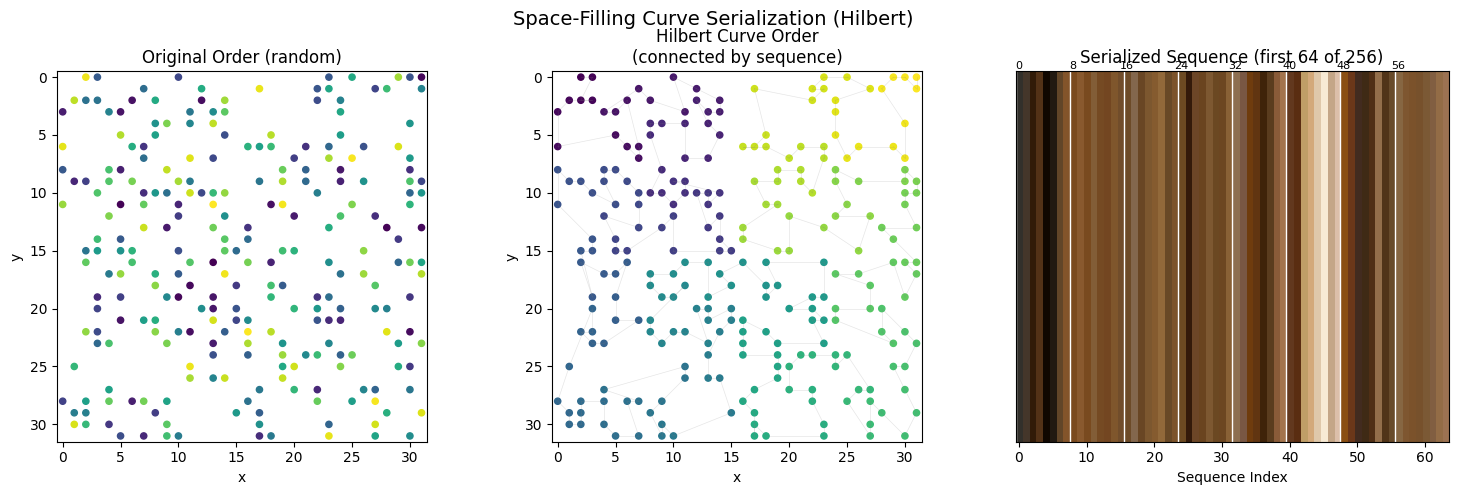


Z-ORDER CURVE SERIALIZATION


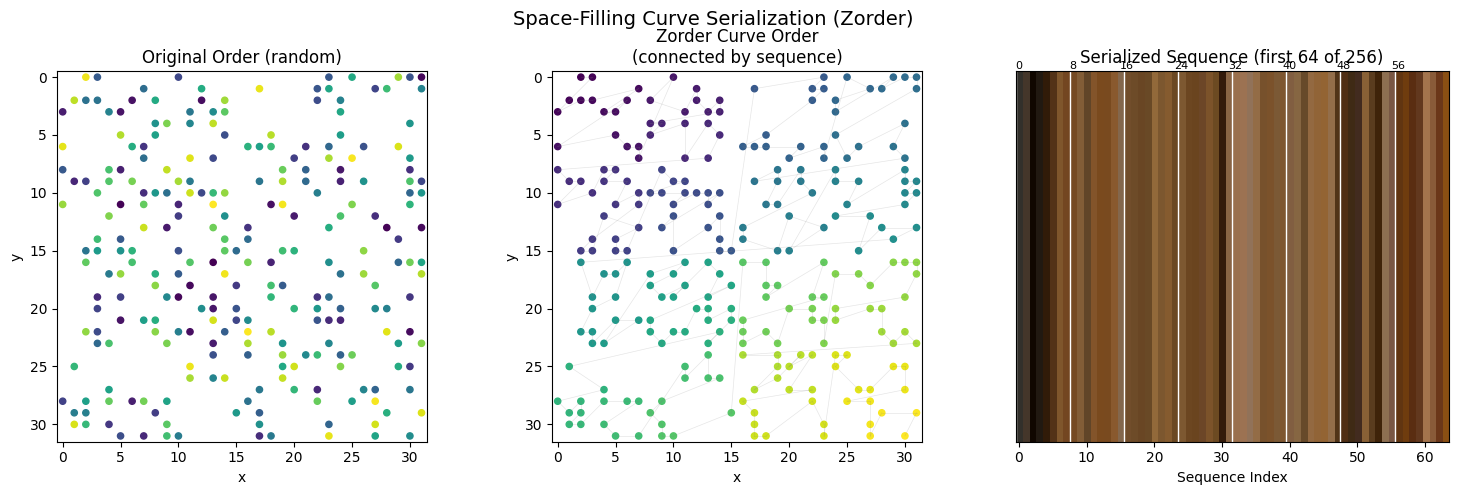

In [7]:
def serialize_with_curve(sparse_coords, curve='hilbert', size=32):
    """
    Serialize sparse 2D coordinates using a space-filling curve.
    
    Args:
        sparse_coords: List of (x, y) coordinates
        curve: 'hilbert' or 'zorder'
        size: Grid size (32 for 32×32)
    
    Returns:
        sorted_coords: Coordinates sorted by curve index
        sorted_indices: Original indices after sorting
        curve_values: Curve index for each point
    """
    order = int(np.log2(size))
    
    if curve == 'hilbert':
        curve_func = lambda x, y: xy_to_hilbert(x, y, order)
    else:  # zorder
        curve_func = lambda x, y: xy_to_zorder(x, y, order)
    
    # Compute curve index for each point
    curve_values = [curve_func(x, y) for x, y in sparse_coords]
    
    # Sort by curve index
    sorted_data = sorted(enumerate(zip(sparse_coords, curve_values)), 
                         key=lambda x: x[1][1])
    
    sorted_indices = [d[0] for d in sorted_data]
    sorted_coords = [d[1][0] for d in sorted_data]
    sorted_curve_values = [d[1][1] for d in sorted_data]
    
    return sorted_coords, sorted_indices, sorted_curve_values


def visualize_serialization(image, sparse_coords, sparse_values, curve='hilbert'):
    """
    Visualize how sparse points are serialized using space-filling curve.
    """
    C, H, W = image.shape
    
    sorted_coords, sorted_indices, curve_values = serialize_with_curve(
        sparse_coords, curve=curve, size=W
    )
    sorted_values = sparse_values[sorted_indices]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original sparse points (colored by original order)
    xs = [c[0] for c in sparse_coords]
    ys = [c[1] for c in sparse_coords]
    colors_orig = plt.cm.viridis(np.linspace(0, 1, len(sparse_coords)))
    axes[0].scatter(xs, ys, c=colors_orig, s=20)
    axes[0].set_xlim(-0.5, W - 0.5)
    axes[0].set_ylim(H - 0.5, -0.5)
    axes[0].set_aspect('equal')
    axes[0].set_title("Original Order (random)")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    
    # Sorted by curve (colored by new order)
    xs_sorted = [c[0] for c in sorted_coords]
    ys_sorted = [c[1] for c in sorted_coords]
    colors_sorted = plt.cm.viridis(np.linspace(0, 1, len(sorted_coords)))
    axes[1].scatter(xs_sorted, ys_sorted, c=colors_sorted, s=20)
    
    # Draw path connecting consecutive points
    for i in range(len(sorted_coords) - 1):
        axes[1].plot([xs_sorted[i], xs_sorted[i+1]], 
                     [ys_sorted[i], ys_sorted[i+1]], 
                     'gray', alpha=0.2, linewidth=0.5)
    
    axes[1].set_xlim(-0.5, W - 0.5)
    axes[1].set_ylim(H - 0.5, -0.5)
    axes[1].set_aspect('equal')
    axes[1].set_title(f"{curve.capitalize()} Curve Order\n(connected by sequence)")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    
    # Show sequence as 1D strip
    # Display first 64 points as colored squares
    n_show = min(64, len(sorted_coords))
    seq_img = np.zeros((8, n_show, 3))
    for i in range(n_show):
        seq_img[:, i, :] = sorted_values[i].numpy()
    
    axes[2].imshow(seq_img, aspect='auto')
    axes[2].set_title(f"Serialized Sequence (first {n_show} of {len(sorted_coords)})")
    axes[2].set_xlabel("Sequence Index")
    axes[2].set_yticks([])
    
    # Add index markers
    for i in range(0, n_show, 8):
        axes[2].axvline(x=i - 0.5, color='white', linewidth=1)
        axes[2].text(i, -0.5, str(i), ha='center', va='bottom', fontsize=8)
    
    plt.suptitle(f"Space-Filling Curve Serialization ({curve.capitalize()})", fontsize=14)
    plt.tight_layout()
    
    return sorted_coords, sorted_indices, sorted_values, fig


# Visualize serialization with both curves
print("=" * 60)
print("HILBERT CURVE SERIALIZATION")
print("=" * 60)
sorted_coords_h, sorted_indices_h, sorted_values_h, fig = visualize_serialization(
    sample_img, sparse_coords, sparse_values, curve='hilbert'
)
plt.show()

print("\n" + "=" * 60)
print("Z-ORDER CURVE SERIALIZATION")
print("=" * 60)
sorted_coords_z, sorted_indices_z, sorted_values_z, fig = visualize_serialization(
    sample_img, sparse_coords, sparse_values, curve='zorder'
)
plt.show()

## Part 6: Grouping into Tokens

Now we group every **g=8** consecutive points into a single token:
- 256 sparse points → 256/8 = **32 tokens**

Compare to standard ViT: 64 tokens from regular patches

Key advantage: Each token contains **spatially coherent** points (thanks to space-filling curve)!

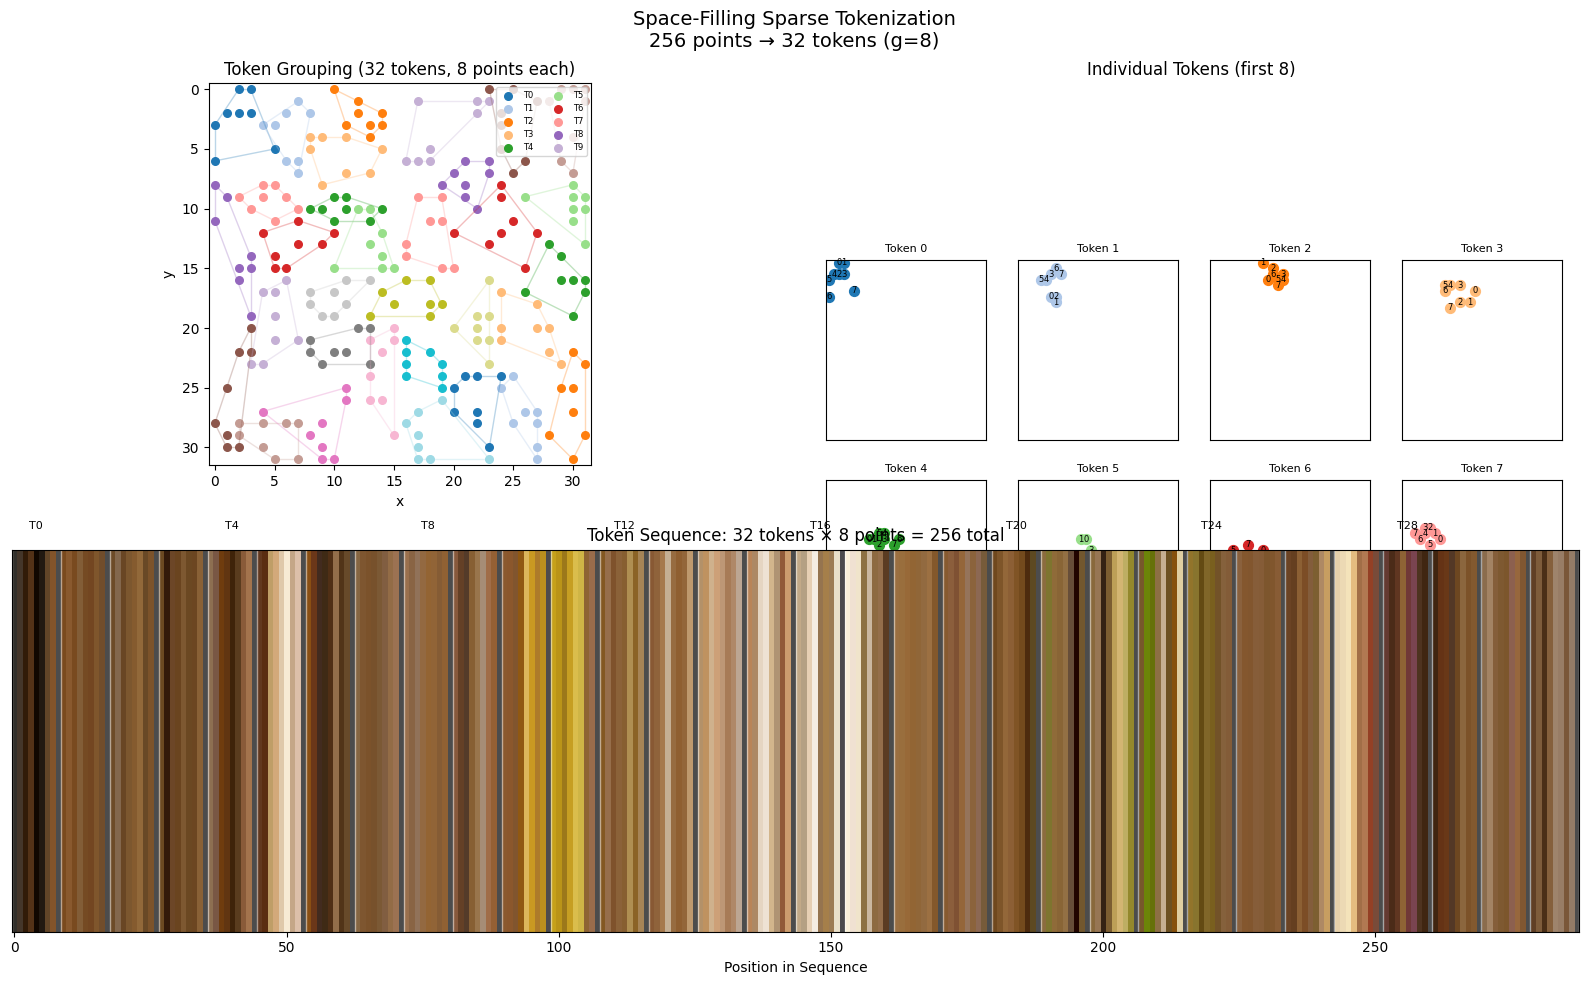


Tokenization Summary:
  Sparse points: 256
  Group size (g): 8
  Number of tokens: 32
  Each token: 8 points × (x, y, RGB) = 40 values


In [9]:
def group_into_tokens(sorted_coords, sorted_values, group_size=8):
    """
    Group consecutive points into tokens.
    
    Args:
        sorted_coords: List of (x, y) sorted by space-filling curve
        sorted_values: Tensor [N, C] of values at those coordinates
        group_size: Number of points per token (g)
    
    Returns:
        tokens: List of token dicts containing coords and values
        num_tokens: Number of tokens created
    """
    n_points = len(sorted_coords)
    num_tokens = n_points // group_size
    
    tokens = []
    for i in range(num_tokens):
        start_idx = i * group_size
        end_idx = start_idx + group_size
        
        token = {
            'token_idx': i,
            'coords': sorted_coords[start_idx:end_idx],
            'values': sorted_values[start_idx:end_idx],
            'start_idx': start_idx,
            'end_idx': end_idx,
        }
        tokens.append(token)
    
    return tokens, num_tokens


def visualize_tokenization(image, sorted_coords, sorted_values, group_size=8):
    """
    Visualize the complete tokenization process.
    """
    C, H, W = image.shape
    tokens, num_tokens = group_into_tokens(sorted_coords, sorted_values, group_size)
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 10))
    
    # Main plot: Show all tokens with different colors
    ax_main = fig.add_subplot(2, 2, 1)
    
    # Generate distinct colors for each token
    token_colors = plt.cm.tab20(np.linspace(0, 1, min(20, num_tokens)))
    
    for token in tokens:
        color = token_colors[token['token_idx'] % 20]
        xs = [c[0] for c in token['coords']]
        ys = [c[1] for c in token['coords']]
        ax_main.scatter(xs, ys, c=[color], s=30, label=f"T{token['token_idx']}" if token['token_idx'] < 10 else None)
        
        # Draw convex hull or bounding box for token
        if len(xs) >= 3:
            from scipy.spatial import ConvexHull
            try:
                points = np.array(list(zip(xs, ys)))
                hull = ConvexHull(points)
                for simplex in hull.simplices:
                    ax_main.plot(points[simplex, 0], points[simplex, 1], 
                                color=color, alpha=0.3, linewidth=1)
            except:
                pass
    
    ax_main.set_xlim(-0.5, W - 0.5)
    ax_main.set_ylim(H - 0.5, -0.5)
    ax_main.set_aspect('equal')
    ax_main.set_title(f"Token Grouping ({num_tokens} tokens, {group_size} points each)")
    ax_main.set_xlabel("x")
    ax_main.set_ylabel("y")
    ax_main.legend(loc='upper right', fontsize=6, ncol=2)
    
    # Show individual tokens in detail
    ax_detail = fig.add_subplot(2, 2, 2)
    
    # Show first 8 tokens in a grid
    n_show = min(8, num_tokens)
    for i in range(n_show):
        token = tokens[i]
        color = token_colors[i % 20]
        
        # Create small subplot
        ax_sub = fig.add_axes([0.52 + (i % 4) * 0.12, 0.55 - (i // 4) * 0.22, 0.1, 0.18])
        
        xs = [c[0] for c in token['coords']]
        ys = [c[1] for c in token['coords']]
        
        # Plot on original image scale
        ax_sub.scatter(xs, ys, c=[color], s=50)
        for j, (x, y) in enumerate(token['coords']):
            ax_sub.annotate(str(j), (x, y), fontsize=6, ha='center', va='center')
        
        ax_sub.set_xlim(-0.5, W - 0.5)
        ax_sub.set_ylim(H - 0.5, -0.5)
        ax_sub.set_title(f"Token {i}", fontsize=8)
        ax_sub.set_xticks([])
        ax_sub.set_yticks([])
    
    ax_detail.axis('off')
    ax_detail.set_title("Individual Tokens (first 8)")
    
    # Token sequence visualization
    ax_seq = fig.add_subplot(2, 1, 2)
    
    # Create image showing token values as colored blocks
    seq_height = 4
    seq_img = np.zeros((seq_height, num_tokens * (group_size + 1), 3))
    
    for i, token in enumerate(tokens):
        color = token_colors[i % 20][:3]  # RGB
        
        for j in range(group_size):
            col = i * (group_size + 1) + j
            # Use actual pixel values
            val = token['values'][j].numpy()
            seq_img[:, col, :] = val
        
        # Add separator
        seq_img[:, i * (group_size + 1) + group_size, :] = [0.3, 0.3, 0.3]
    
    ax_seq.imshow(seq_img, aspect='auto')
    ax_seq.set_title(f"Token Sequence: {num_tokens} tokens × {group_size} points = {num_tokens * group_size} total")
    ax_seq.set_xlabel("Position in Sequence")
    ax_seq.set_yticks([])
    
    # Add token boundary markers
    for i in range(num_tokens + 1):
        x = i * (group_size + 1) - 0.5
        ax_seq.axvline(x=x, color='white', linewidth=1, alpha=0.5)
    
    # Add token index labels
    for i in range(0, num_tokens, 4):
        x = i * (group_size + 1) + group_size / 2
        ax_seq.text(x, -0.8, f"T{i}", ha='center', va='top', fontsize=8)
    
    plt.suptitle(f"Space-Filling Sparse Tokenization\n256 points → {num_tokens} tokens (g={group_size})", fontsize=14)
    plt.tight_layout()
    
    return tokens, fig


# Visualize tokenization
GROUP_SIZE = 8
tokens, fig = visualize_tokenization(sample_img, sorted_coords_h, sorted_values_h, group_size=GROUP_SIZE)
plt.show()

print(f"\nTokenization Summary:")
print(f"  Sparse points: {len(sparse_coords)}")
print(f"  Group size (g): {GROUP_SIZE}")
print(f"  Number of tokens: {len(tokens)}")
print(f"  Each token: {GROUP_SIZE} points × (x, y, RGB) = {GROUP_SIZE * 5} values")

## Part 7: Complete Pipeline Visualization

Let's visualize the complete pipeline from original image to tokens.

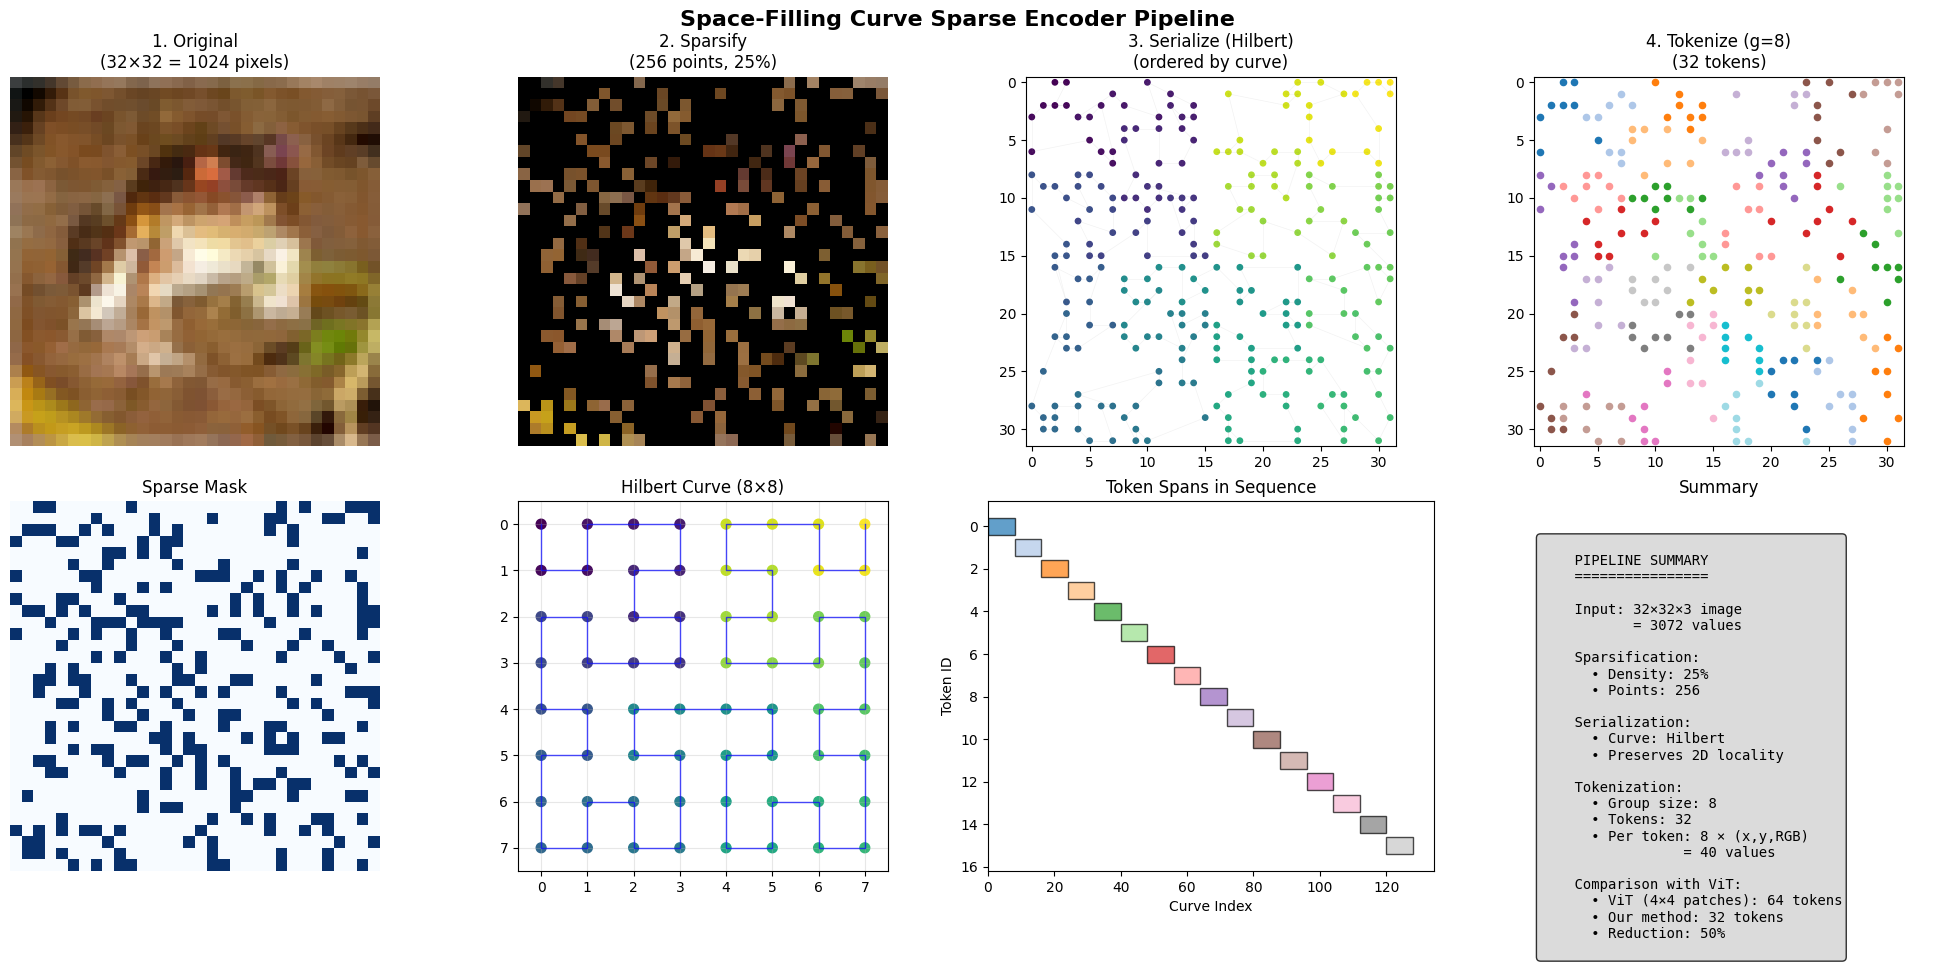

In [10]:
def complete_pipeline_visualization(image, sparsity=0.25, group_size=8, curve='hilbert', seed=42):
    """
    Complete visualization of the sparse tokenization pipeline.
    """
    C, H, W = image.shape
    
    # Step 1: Sparsify
    sparse_coords, sparse_values, mask = sparsify_image(image, sparsity, seed)
    
    # Step 2: Serialize with space-filling curve
    sorted_coords, sorted_indices, curve_values = serialize_with_curve(
        sparse_coords, curve=curve, size=W
    )
    sorted_values = sparse_values[sorted_indices]
    
    # Step 3: Group into tokens
    tokens, num_tokens = group_into_tokens(sorted_coords, sorted_values, group_size)
    
    # Create comprehensive figure
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Row 1: The process
    # 1a. Original image
    axes[0, 0].imshow(image.permute(1, 2, 0))
    axes[0, 0].set_title(f"1. Original\n({H}×{W} = {H*W} pixels)")
    axes[0, 0].axis('off')
    
    # 1b. Sparsified
    sparse_img = torch.zeros_like(image)
    for (x, y), val in zip(sparse_coords, sparse_values):
        sparse_img[:, y, x] = val
    axes[0, 1].imshow(sparse_img.permute(1, 2, 0))
    axes[0, 1].set_title(f"2. Sparsify\n({len(sparse_coords)} points, {sparsity*100:.0f}%)")
    axes[0, 1].axis('off')
    
    # 1c. Serialized (show path)
    xs = [c[0] for c in sorted_coords]
    ys = [c[1] for c in sorted_coords]
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_coords)))
    axes[0, 2].scatter(xs, ys, c=colors, s=15)
    for i in range(len(sorted_coords) - 1):
        axes[0, 2].plot([xs[i], xs[i+1]], [ys[i], ys[i+1]], 'gray', alpha=0.1, linewidth=0.5)
    axes[0, 2].set_xlim(-0.5, W - 0.5)
    axes[0, 2].set_ylim(H - 0.5, -0.5)
    axes[0, 2].set_aspect('equal')
    axes[0, 2].set_title(f"3. Serialize ({curve.capitalize()})\n(ordered by curve)")
    
    # 1d. Tokenized
    token_colors = plt.cm.tab20(np.linspace(0, 1, min(20, num_tokens)))
    for token in tokens:
        color = token_colors[token['token_idx'] % 20]
        xs = [c[0] for c in token['coords']]
        ys = [c[1] for c in token['coords']]
        axes[0, 3].scatter(xs, ys, c=[color], s=20)
    axes[0, 3].set_xlim(-0.5, W - 0.5)
    axes[0, 3].set_ylim(H - 0.5, -0.5)
    axes[0, 3].set_aspect('equal')
    axes[0, 3].set_title(f"4. Tokenize (g={group_size})\n({num_tokens} tokens)")
    
    # Row 2: Details
    # 2a. Mask
    axes[1, 0].imshow(mask, cmap='Blues')
    axes[1, 0].set_title("Sparse Mask")
    axes[1, 0].axis('off')
    
    # 2b. Curve visualization on full grid
    # Show Hilbert curve path on 8x8 grid for clarity
    order_small = 3  # 8x8
    size_small = 8
    points_small = [hilbert_to_xy(i, order_small) for i in range(size_small * size_small)]
    xs_small = [p[0] for p in points_small]
    ys_small = [p[1] for p in points_small]
    
    axes[1, 1].plot(xs_small, ys_small, 'b-', linewidth=1, alpha=0.7)
    axes[1, 1].scatter(xs_small, ys_small, c=np.arange(len(points_small)), cmap='viridis', s=50)
    axes[1, 1].set_xlim(-0.5, size_small - 0.5)
    axes[1, 1].set_ylim(size_small - 0.5, -0.5)
    axes[1, 1].set_aspect('equal')
    axes[1, 1].set_title(f"{curve.capitalize()} Curve (8×8)")
    axes[1, 1].grid(True, alpha=0.3)
    
    # 2c. Token content visualization
    # Show how tokens are distributed in curve index space
    token_starts = [tokens[i]['start_idx'] for i in range(num_tokens)]
    token_ends = [tokens[i]['end_idx'] for i in range(num_tokens)]
    
    for i in range(min(16, num_tokens)):
        axes[1, 2].barh(i, group_size, left=token_starts[i], 
                       color=token_colors[i % 20], alpha=0.7, edgecolor='black')
    axes[1, 2].set_xlabel("Curve Index")
    axes[1, 2].set_ylabel("Token ID")
    axes[1, 2].set_title("Token Spans in Sequence")
    axes[1, 2].invert_yaxis()
    
    # 2d. Summary statistics
    summary_text = f"""
    PIPELINE SUMMARY
    ================
    
    Input: {H}×{W}×{C} image
           = {H*W*C} values
    
    Sparsification:
      • Density: {sparsity*100:.0f}%
      • Points: {len(sparse_coords)}
    
    Serialization:
      • Curve: {curve.capitalize()}
      • Preserves 2D locality
    
    Tokenization:
      • Group size: {group_size}
      • Tokens: {num_tokens}
      • Per token: {group_size} × (x,y,RGB)
                 = {group_size * 5} values
    
    Comparison with ViT:
      • ViT (4×4 patches): 64 tokens
      • Our method: {num_tokens} tokens
      • Reduction: {(1 - num_tokens/64)*100:.0f}%
    """
    axes[1, 3].text(0.1, 0.9, summary_text, transform=axes[1, 3].transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1, 3].axis('off')
    axes[1, 3].set_title("Summary")
    
    plt.suptitle("Space-Filling Curve Sparse Encoder Pipeline", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return {
        'sparse_coords': sparse_coords,
        'sparse_values': sparse_values,
        'sorted_coords': sorted_coords,
        'sorted_values': sorted_values,
        'tokens': tokens,
        'num_tokens': num_tokens,
    }, fig


# Run complete pipeline
result, fig = complete_pipeline_visualization(
    sample_img, 
    sparsity=0.25, 
    group_size=8, 
    curve='hilbert',
    seed=42
)
plt.show()

## Part 8: Multiple Examples

Let's see how this works across different CIFAR-10 images.

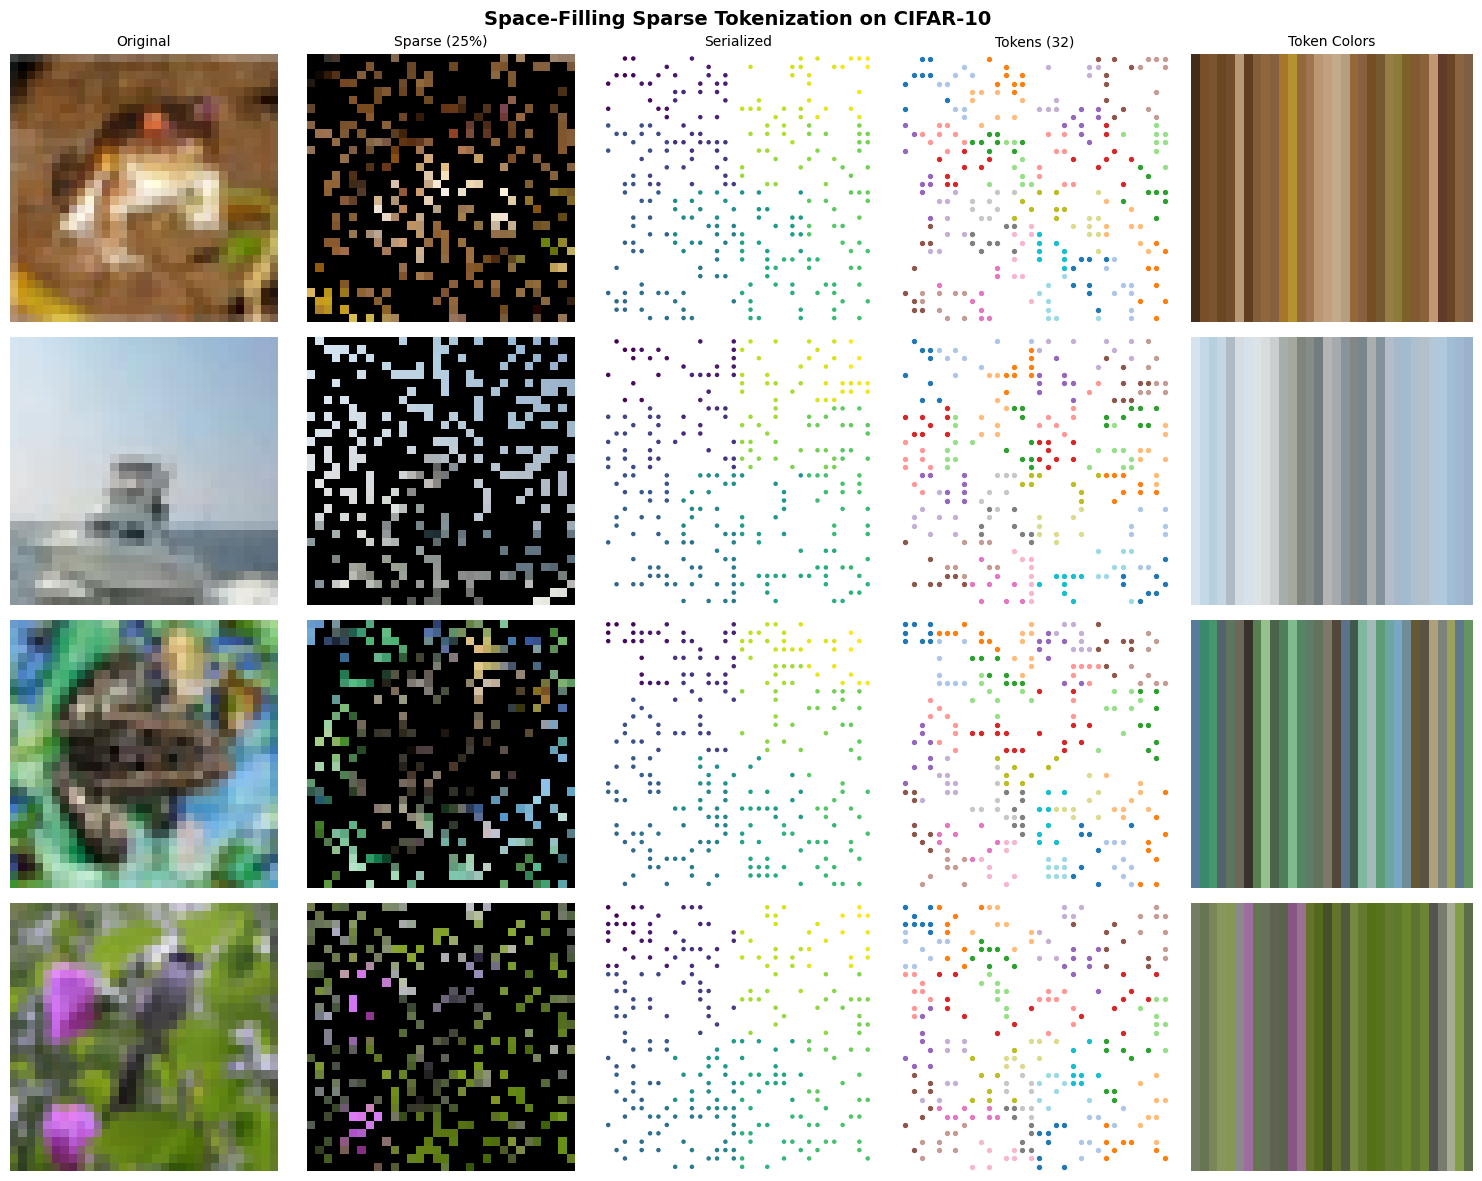

In [11]:
# Process multiple CIFAR-10 images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for row in range(4):
    img, label = cifar10[row * 100]  # Sample every 100th image
    
    # Sparsify
    sparse_coords, sparse_values, mask = sparsify_image(img, 0.25, seed=42+row)
    sorted_coords, sorted_indices, _ = serialize_with_curve(sparse_coords, 'hilbert', 32)
    sorted_values = sparse_values[sorted_indices]
    tokens, num_tokens = group_into_tokens(sorted_coords, sorted_values, 8)
    
    # Original
    axes[row, 0].imshow(img.permute(1, 2, 0))
    axes[row, 0].set_title(f"{CIFAR10_CLASSES[label]}" if row == 0 else "")
    axes[row, 0].axis('off')
    if row == 0:
        axes[row, 0].set_title("Original", fontsize=10)
    axes[row, 0].set_ylabel(CIFAR10_CLASSES[label], fontsize=10)
    
    # Sparse
    sparse_img = torch.zeros_like(img)
    for (x, y), val in zip(sparse_coords, sparse_values):
        sparse_img[:, y, x] = val
    axes[row, 1].imshow(sparse_img.permute(1, 2, 0))
    axes[row, 1].axis('off')
    if row == 0:
        axes[row, 1].set_title("Sparse (25%)", fontsize=10)
    
    # Serialized
    xs = [c[0] for c in sorted_coords]
    ys = [c[1] for c in sorted_coords]
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_coords)))
    axes[row, 2].scatter(xs, ys, c=colors, s=5)
    axes[row, 2].set_xlim(-0.5, 31.5)
    axes[row, 2].set_ylim(31.5, -0.5)
    axes[row, 2].set_aspect('equal')
    axes[row, 2].axis('off')
    if row == 0:
        axes[row, 2].set_title("Serialized", fontsize=10)
    
    # Tokenized
    token_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    for token in tokens:
        color = token_colors[token['token_idx'] % 20]
        xs = [c[0] for c in token['coords']]
        ys = [c[1] for c in token['coords']]
        axes[row, 3].scatter(xs, ys, c=[color], s=8)
    axes[row, 3].set_xlim(-0.5, 31.5)
    axes[row, 3].set_ylim(31.5, -0.5)
    axes[row, 3].set_aspect('equal')
    axes[row, 3].axis('off')
    if row == 0:
        axes[row, 3].set_title(f"Tokens ({num_tokens})", fontsize=10)
    
    # Token sequence
    seq_img = np.zeros((4, num_tokens, 3))
    for i, token in enumerate(tokens):
        # Average color of token
        avg_color = token['values'].mean(dim=0).numpy()
        seq_img[:, i, :] = avg_color
    axes[row, 4].imshow(seq_img, aspect='auto')
    axes[row, 4].axis('off')
    if row == 0:
        axes[row, 4].set_title("Token Colors", fontsize=10)

plt.suptitle("Space-Filling Sparse Tokenization on CIFAR-10", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary

### What We Built

A **sparse encoder** that converts irregular 2D point data into transformer tokens:

1. **Sparsification**: Random sampling to 25% density (256 points from 32×32)
2. **Serialization**: Space-filling curve (Hilbert/Z-order) orders 2D points in 1D
3. **Tokenization**: Group every g=8 consecutive points into a token → 32 tokens

### Key Advantages

| Aspect | Standard ViT | Space-Filling Sparse |
|--------|-------------|---------------------|
| Input | Dense grid | Sparse/irregular points |
| Locality | Patch-based | Curve-based (better!) |
| Tokens | 64 (fixed grid) | 32 (adaptive) |
| Flexibility | Fixed resolution | Any point distribution |

### Applications

- **LiDAR point clouds**: Sparse 3D sensing
- **Sparse sensors**: Irregular measurement grids
- **Masked images**: Inpainting with partial observations
- **Efficient transformers**: Reduced token count

### Next Steps

1. **Positional encoding**: Encode (x, y) positions for transformer
2. **Token embedding**: Project grouped points to hidden dimension
3. **Transformer encoder**: Self-attention on sparse tokens
4. **Applications**: Classification, reconstruction, generation